# 分类 {#sec-cla}

这一章我们学习如何用贝叶斯统计来做分类。

## 数据

In [1]:
from scipy.stats import multivariate_normal
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "notebook"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from collections import Counter 

def normalize_array(arr):
    return np.array([i/np.sum(arr) for i in arr])

使用 `scipy`：

```py
norm.pdf(x, loc, scale)
```

可以得到正态分布 $\mathcal{N}(\text{loc}, \text{scale}^2)$ 在 $x$ 的密度值。所以 `loc` 是 $\mu$、`scale` 是 $\sigma$. 

我们这次需要再次用到 `penguins` 这个数据 (@gorman2014ecological)。

我们需要确保 `body_mass_g` 不为空。

In [2]:
penguins = sns.load_dataset("penguins")
penguins = penguins.dropna(subset=['body_mass_g'])
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [3]:
print(penguins.shape)

(342, 7)


我们的目标是用下面的四个 `predictors` 来预测 `species`：

In [4]:
predictors = list(penguins.columns[2:-1])
predictors

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

In [5]:
species = penguins.species.unique()
species

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

我们先来看一下这四个自变量的分布：

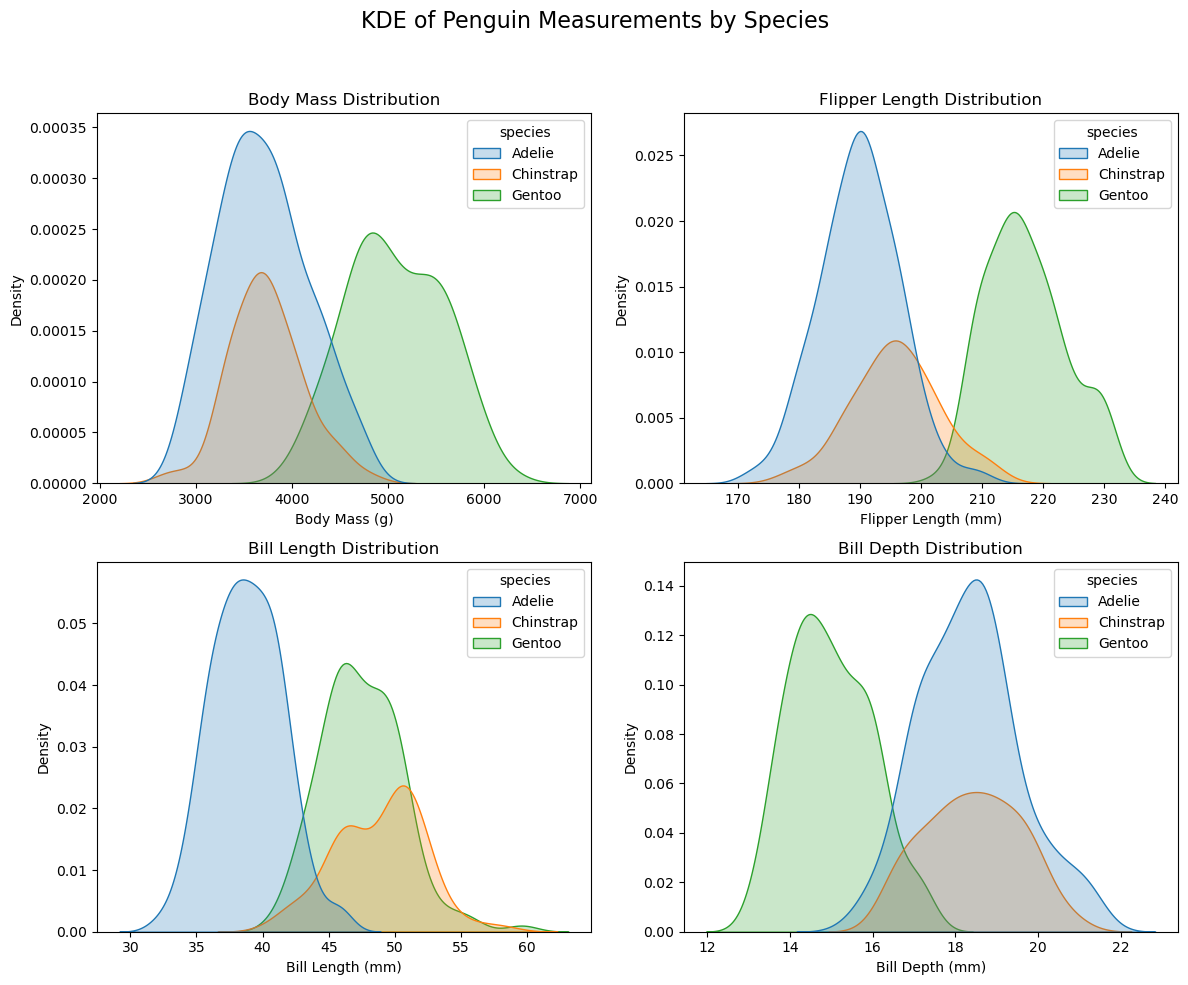

In [6]:
#| code-fold: true
# <!-- fig-penguin-distribution -->

# Set up the 2x2 grid for KDE plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("KDE of Penguin Measurements by Species", fontsize=16)

# KDE plot 1: Body Mass
sns.kdeplot(data=penguins, x="body_mass_g", hue="species", ax=axes[0, 0], fill=True)
axes[0, 0].set_title("Body Mass Distribution")
axes[0, 0].set_xlabel("Body Mass (g)")
axes[0, 0].set_ylabel("Density")

# KDE plot 2: Flipper Length
sns.kdeplot(data=penguins, x="flipper_length_mm", hue="species", ax=axes[0, 1], fill=True)
axes[0, 1].set_title("Flipper Length Distribution")
axes[0, 1].set_xlabel("Flipper Length (mm)")
axes[0, 1].set_ylabel("Density")

# KDE plot 3: Bill Length
sns.kdeplot(data=penguins, x="bill_length_mm", hue="species", ax=axes[1, 0], fill=True)
axes[1, 0].set_title("Bill Length Distribution")
axes[1, 0].set_xlabel("Bill Length (mm)")
axes[1, 0].set_ylabel("Density")

# KDE plot 4: Bill Depth
sns.kdeplot(data=penguins, x="bill_depth_mm", hue="species", ax=axes[1, 1], fill=True)
axes[1, 1].set_title("Bill Depth Distribution")
axes[1, 1].set_xlabel("Bill Depth (mm)")
axes[1, 1].set_ylabel("Density")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 原理

我们想要的是 $P(\text{Species}| \text{Data})$，依据贝叶斯定理：

$$P(\text{Species}| \text{Data}) \propto P(\text{Species}) \cdot P(\text{Data}|\text{Species})$$

这里 Data 可以是一组数，比如四个自变量的值，也可以是一个数，也就是一个自变量的值。我们先来处理只有一个数据点，也就是我们只知道一个自变量的情况。

先来看 $P(\text{Species})$，也就是先验概率：在我们什么数据都没有的情况下，预测三者的概率。

第一个选择是 Uniform prior:

In [7]:
# prior of species
prior = dict(zip(species, np.array([1/3]*3)))
prior 

{'Adelie': 0.3333333333333333,
 'Chinstrap': 0.3333333333333333,
 'Gentoo': 0.3333333333333333}

第二个选择是 Empirical prior:

In [8]:
total = len(penguins)
empirical_prior = {
    species: count/total for species, count in Counter(
        penguins.species).items()}
empirical_prior

{'Adelie': 0.4415204678362573,
 'Chinstrap': 0.19883040935672514,
 'Gentoo': 0.35964912280701755}

那如何求 $P(\text{Data}|\text{Species})$？

Data 是一个数字。比如，我们知道了 'flipper_length_mm': 193。如何知道这个数字对于 'Adelie' 来说，概率多大？

通过上图 (KDE of Penguin Measurements by Species)，我们看到各个分布基本符合正态分布。那我们用 `penguins` 中 'Adelie' 所有的 'flipper_length_mm' 数据，计算出平均值和标准差，就可以估算出 'Adelie' 之 'flipper_length_mm' 的正态分布。对其他的 Species 也一样。这样，对于 'flipper_length_mm': 193 我们就可以算出三个 Species 相对应的 Density，这就是似然。

我们先来把所有的变量的参数算出来：

In [9]:
def get_all_dist(penguins, predictors):
    res = {}
    for s, group_data in penguins.groupby("species"):
        dic = {}
        # res[s] = dic
        for p in predictors:
            dic[p] = {}
            data = group_data[p]
            mu = np.mean(data)
            sigma = np.std(data)
            dic[p]['mean'] = mu 
            dic[p]['sigma'] = sigma 
        res[s] = dic
    return res

In [10]:
likelihood = get_all_dist(penguins, predictors)
likelihood

{'Adelie': {'bill_length_mm': {'mean': 38.79139072847682,
   'sigma': 2.654570977106625},
  'bill_depth_mm': {'mean': 18.34635761589404, 'sigma': 1.2126144287882996},
  'flipper_length_mm': {'mean': 189.95364238410596,
   'sigma': 6.517767614763347},
  'body_mass_g': {'mean': 3700.662251655629, 'sigma': 457.04517271224495}},
 'Chinstrap': {'bill_length_mm': {'mean': 48.83382352941177,
   'sigma': 3.314611604171021},
  'bill_depth_mm': {'mean': 18.42058823529412, 'sigma': 1.1270156874957824},
  'flipper_length_mm': {'mean': 195.8235294117647, 'sigma': 7.079259633253841},
  'body_mass_g': {'mean': 3733.0882352941176, 'sigma': 381.4986213564681}},
 'Gentoo': {'bill_length_mm': {'mean': 47.50487804878048,
   'sigma': 3.0693039294185516},
  'bill_depth_mm': {'mean': 14.98211382113821, 'sigma': 0.9772229210631793},
  'flipper_length_mm': {'mean': 217.1869918699187,
   'sigma': 6.4585603287620605},
  'body_mass_g': {'mean': 5076.016260162602, 'sigma': 502.0628014961637}}}

然后，先验与似然相乘，再标准化 (Normalize) 一下，就是 Posterior 了：

In [11]:
def update_post(varname, varvalue, prior, likelihood):
    res = {}
    for s, s_prior in prior.items():
        mu = likelihood[s][varname]['mean']
        sigma = likelihood[s][varname]['sigma']
        pdf = norm.pdf(varvalue, loc = mu, scale = sigma)
        res[s] = s_prior * pdf 
    
    normalized_res_values = normalize_array(np.array(list(res.values())))
    res = dict(zip(res.keys(), normalized_res_values))
    return res 

In [12]:
post_flipper = update_post('flipper_length_mm', 193, prior, likelihood)
post_flipper

{'Adelie': 0.5129670276270746,
 'Chinstrap': 0.48651288781448715,
 'Gentoo': 0.0005200845584382924}

我们看到，结果显示，在 flipper_length_mm': 193 这一数据下，结果几乎不可能是 Gentoo，但我们没办法确认到底是 Adelie 还是 Chinstrap，这一点从上图中也可以反映出来。

那如果我们有另外一个数据呢？比如，'bill_length_mm':48。我们依然可以用先验与似然相乘。但是这里要注意的是，这里的先验是我们上面的结果，`post_flipper`:

In [13]:
post_flipper_bill_length = update_post(
    'bill_length_mm', 48, post_flipper, likelihood)
post_flipper_bill_length

{'Adelie': 0.003297190719649734,
 'Chinstrap': 0.9955319128234549,
 'Gentoo': 0.0011708964568953224}

我们看到，几乎可以肯定是 'Chinstrap'。

那我们来看一下如何直接使用多个数据：

In [14]:
data = {
    'flipper_length_mm': 193, 
    'bill_length_mm': 48
}

In [15]:
def update_naive(data, prior, likelihood):
    posterior = prior.copy()
    for varname, varvalue in data.items():
        posterior = update_post(varname, varvalue, posterior, likelihood)
    return posterior

In [16]:
res = update_naive(data, prior, likelihood)
res 

{'Adelie': 0.003297190719649734,
 'Chinstrap': 0.9955319128234549,
 'Gentoo': 0.0011708964568953224}

结果和上面一样。

## 朴素贝叶斯分类 (Naive Bayesian Classification)

接下来，我们对 `penguins` 中每一行进行预测：

In [17]:
penguins['Classification'] = 'None'
for i, row in penguins.iterrows():
    data = dict(row[predictors])
    res = update_naive(data, prior, likelihood)
    pred = max(res, key = res.get)
    penguins.loc[i, 'Classification'] = pred 

In [18]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,Classification
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,Adelie
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,Adelie
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,Adelie
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,Adelie
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,Adelie


In [19]:
valid = penguins['Classification'].notna()
valid.sum()

342

In [20]:
same = penguins['species'] == penguins['Classification']
same.sum()

331

In [21]:
same.sum() / valid.sum()

0.9678362573099415

我们再来看一下如果用 Empirical prior 结果会如何：

In [22]:
penguins['Classification'] = 'None'
for i, row in penguins.iterrows():
    data = dict(row[predictors])
    res = update_naive(data, empirical_prior, likelihood)
    pred = max(res, key = res.get)
    penguins.loc[i, 'Classification'] = pred

valid = penguins['Classification'].notna()
same = penguins['species'] == penguins['Classification']
same.sum() / valid.sum()

0.9707602339181286

我们看到用 Empirical prior 的结果更好一些。

## 联合分布 (Join Distribution)

现在我们来反思一下。如果我们的数据是 $X_1, X_2, ..., X_n$，某一 Species 我们记为 $C$。那根据最基本的概率知识，我们也知道，如果 $X_1, X_2, ..., X_n$ 之间彼此独立，那么：

$$P(X_1, X_2, ..., X_n|C) = P(X_1|C) \cdot P(X_2|C) \cdots P(X_n|C)$$

所以：

$$
P(C|X_1, X_2, ..., X_n) \propto P(C) \cdot P(X_1, X_2, ..., X_n|C)
$$ {#eq-post-cal}

但问题是，「$X_1, X_2, ..., X_n$ 之间彼此独立」这一点未必站得住脚。

如果两个变量完全不相关，结果会是这样：

<!-- ## 多元正态分布 (Multivariate Normal Distribution) -->

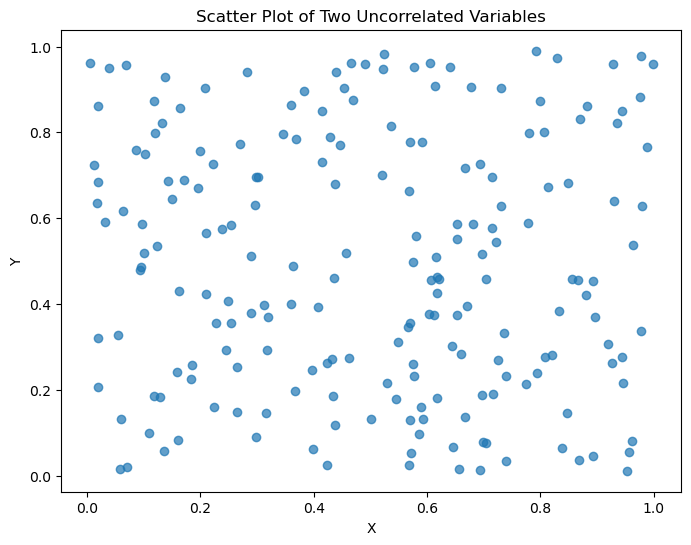

In [23]:
#| code-fold: true 

np.random.seed(0)
x = np.random.rand(200)
y = np.random.rand(200)

plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha = 0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Two Uncorrelated Variables')
plt.show()

但是在 `penguins` 这一数据中，我们拿 `flipper_length_mm` 和 `bill_length_mm` 来举例子：

In [24]:
#| code-fold: true

def scatterplot(df, var1, var2):
    plt.figure(figsize=(10,8))
    sns.scatterplot(
        data = df,
        x = var1, 
        y = var2, 
        hue='species',
        palette='colorblind',
        s = 100, 
        alpha = 0.7
    )
    plt.xlim(0)
    plt.ylim(0)
    plt.axis("equal")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'Scatter Plot of {var1} vs. {var2} by Species')
    plt.legend(title = "Species")
    plt.show()

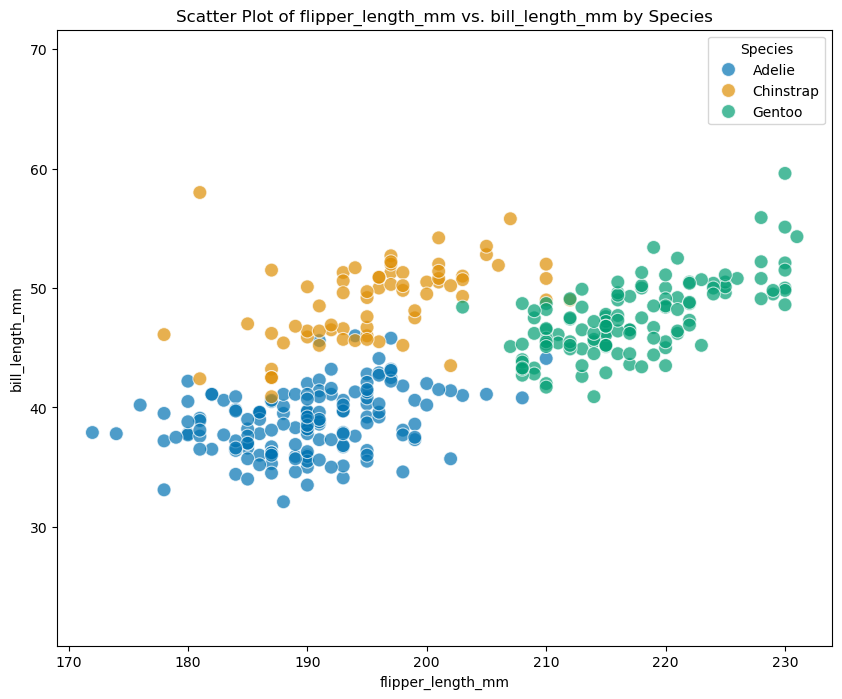

In [25]:
scatterplot(penguins, predictors[2], predictors[0])

很明显，对于每一个 Species 来说，这两个变量很明显是相关的，而不是完全不相关。

那对于两个相关的变量

$$P(X_1, X_2|C) = P(X_1|C) \cdot P(X_2|C)$$

并不成立。正确的计算方法是：

$$P(X_1, X_2|C) = P(X_1|C) \cdot P(X_2|X_1, C)$$

我们来举一个例子：

- $S$: 夏天
- $W$: 晴天 (1) 还是阴天 (0)
- $H$；喝热饮 (1)或者不喝 (0)

我们现在知道：

- $P(W=1|S) = 0.7$
- $P(W=0|S) = 0.3$
- $P(H=1 | W=1, S) = 0.2$
- $P(H=1 | W=0, S) = 0.6$

这里首先要立即，夏天+天晴的时候喝热饮 和 夏天+阴天的时候喝热饮 这两者是相互独立的，两者相加之和并不保证为 1。

现在我们首先来看一下如何计算 $P(H=1|S)$:

$$P(H=1 | W=1, S) \cdot P(W=1|S) + P(H=1 | W=0, S) * P(W=0|S) = 0.32$$

In [26]:
0.7*0.2 + 0.3*0.6

0.31999999999999995

我们现在知道了 

- $P(H=1|S) = 0.32$

我们现在想看看

$$P(H=1,W=1|S) = P(W=1|S) \cdot P(H=1|S)$$

和

$$P(H=1,W=1|S) = P(W=1|S) \cdot P(H=1|W=1, S)$$

这两个到底哪个对。

我们用编程来模拟一万天的记录：

In [27]:
#| code-fold: true

n_samples = 10**4

p_sunny_given_summer = 0.7
p_drink_given_sunny = 0.2
p_drink_given_cloudy = 0.6

weather = np.random.choice(
    [1,0], 
    size = n_samples, 
    p = [p_sunny_given_summer, 
         1- p_sunny_given_summer]
)

drink = np.zeros(n_samples)
drink[weather == 1] = np.random.choice(
    [1,0], size = (weather==1).sum(), 
    p=[p_drink_given_sunny, 1-p_drink_given_sunny])
drink[weather == 0] = np.random.choice(
    [1,0], size = (weather==0).sum(), 
    p=[p_drink_given_cloudy, 1-p_drink_given_cloudy])

joint_prob_actual = ((weather==1) & (drink==1)).sum() / n_samples

print(f"夏天晴天且喝热饮的真实概率是 {joint_prob_actual}。")

p_h_given_s = drink.sum()/n_samples
p_w_given_s = p_sunny_given_summer
joint_prob_independence = p_w_given_s * p_h_given_s
print(f"用 P(W=1 | S) * P(H=1 | S) 算出的结果是: {joint_prob_independence}")

joint_prob_correct = p_w_given_s * p_drink_given_sunny
print(f"用 P(W=1 | S) * P(H=1 | W=1, S) 算出的结果是: {joint_prob_correct}")

夏天晴天且喝热饮的真实概率是 0.1469。
用 P(W=1 | S) * P(H=1 | S) 算出的结果是: 0.22518999999999997
用 P(W=1 | S) * P(H=1 | W=1, S) 算出的结果是: 0.13999999999999999


所以

$$P(H=1,W=1|S) = P(W=1|S) \cdot P(H=1|W=1, S)$$

才是正确的做法。

回到 `penguins` 这个数据，因为自变量之间并非相互独立，正确的计算方法是

$$P(X_1, X_2, ..., X_n|C) =  P(X_1|C) \cdot P(X_2|X_1, C) \cdots P(X_n|X_1, X_2, ... X_{n-1}, C)
$$ {#eq-likelihood-cal}

我们把 $P(X_1, X_2, ..., X_n|C)$ 称为联合概率密度 (Joint probability density) 或者简称为联合密度 (Joint density)。

如果我们只有两个自变量。那密度值是 Z 轴的取值。密度的积分为 1。

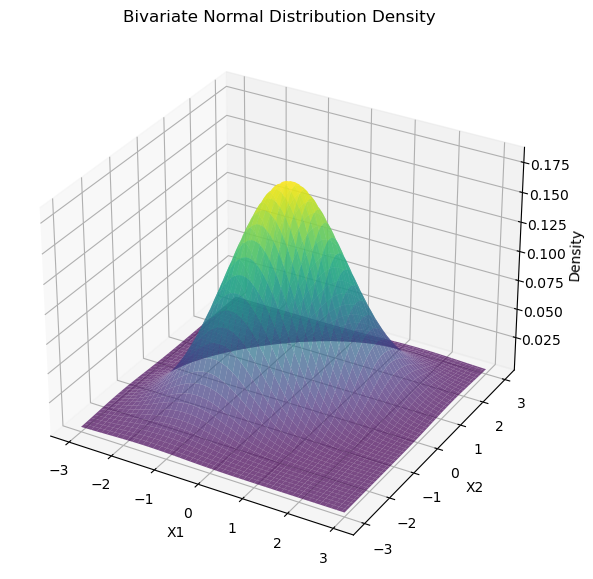

In [28]:
#| code-fold: true

# Define mean and covariance for a bivariate normal distribution
mean = [0, 0]  # Centered at origin
covariance = [[1, 0.5], [0.5, 1]]  # Covariance matrix with some correlation

# Create a grid of points in the x and y range
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Calculate the bivariate normal density at each grid point
rv = multivariate_normal(mean, covariance)
Z = rv.pdf(pos)

# Plotting the density function

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.7)

# Labels and title
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Density')
ax.set_title('Bivariate Normal Distribution Density')
plt.show()

# # Generate the 3D surface plot using Plotly
# surface = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis')
# layout = go.Layout(
#     title="Bivariate Normal Distribution Density (3D Surface)",
#     scene=dict(
#         xaxis_title="X1",
#         yaxis_title="X2",
#         zaxis_title="Density"
#     )
# )
# fig = go.Figure(data=[surface], layout=layout)

# # Display the interactive plot
# fig.show()

我们暂时不去推导具体的公式。目前我们只需要知道，如果有四个自变量 $X_1, X_2, X_3, X_4$，「均值向量」是 `mean_vector`，「协方差矩阵」为 `covariance_matrix`。给定具体的数据 `data`。那么

```py
from scipy.stats import multivariate_normal
rv = multivariate_normal(mean=mean_vector, cov=covariance_matrix)
Z = rv.pdf(data)
```

便可计算联合概率密度，也就是 $P(X_1, X_2, ..., X_n|C)$。

在这种情况下，四个变量构成了四个相互不独立的高斯分布。由此产生的多变量分布称为「多元正态分布」(multivariate normal distribution)。

## 使用多元正态分布

接下来，我们使用多元正态分布来做分类。

我们首先对不同的 Species 计算出相对应的均值向量和协方差矩阵：

In [29]:
mean_cov_dic = {} # key is species and value is mean and cov
for s, group in penguins.groupby('species'):
    mean_vector = group[predictors].mean().values
    covariance_matrix = group[predictors].cov().values 
    mean_cov_dic[s] = {
        'mean': mean_vector,
        'cov': covariance_matrix
    }

然后我们把 @eq-post-cal 和 @eq-likelihood-cal 联合起来用。

In [30]:
def update_multivarate_normal(data, prior, mean_cov_dic):
    res = {}
    for s, s_prior in prior.items():
        mean_vector = mean_cov_dic[s]['mean']
        covariance_matrix = mean_cov_dic[s]['cov']
        rv = multivariate_normal(mean=mean_vector, cov=covariance_matrix)
        z = rv.pdf(data)
        res[s] = s_prior * z 
    normalized_res_values = normalize_array(np.array(list(res.values())))
    res = dict(zip(res.keys(), normalized_res_values))
    return res 

In [31]:
penguins['Classification2'] = 'None'
for i, row in penguins.iterrows():
    data = row[predictors]
    res = update_multivarate_normal(data, prior, mean_cov_dic)
    pred = max(res, key = res.get)
    penguins.loc[i, 'Classification2'] = pred 

In [32]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,Classification,Classification2
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,Adelie,Adelie
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,Adelie,Adelie
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,Adelie,Adelie
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,Adelie,Adelie
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,Adelie,Adelie


In [33]:
valid = penguins['Classification2'].notna()
same = penguins['species'] == penguins['Classification2']
same.sum() / valid.sum()

0.9912280701754386

我们可以看到准确里提高到了 99%。